# Theoretische Grundlagen
Durch die Digitalisierung stieg die Anzahl von digitalen Texten drastisch an und steigt immer noch an, sodass diese kaum noch zu fassen sind. So umfasst das Deutsche Textarchiv (digitale Textsammlung) um die 145 Millionen Texte.
Diese Masse an Texten muss verwaltet werden, sodass Texte gefunden und abgebildet werden können. Des Weiteren müssen sie mit Unterstützung von Computern ausgewertet werden können, da dies manuell kaum machbar wäre.
Im Jahr 2007 beschäftigte sich Franco Moretti innerhalb seines Forschungsprogramms damit, tausend Werke der Weltliteratur gleichzeitig miteinander zu vergleichen. Möglich war dies aber nur mithilfe von (text-) statischen Verfahren und mit computergestützten Visualisierungen. (Heyer, Wiedemann, Niekler 2020, S.351-353)

# Topic Modeling
Topic Modelling ist eine bekannte Klasse dieser statischen Verfahren. Hierbei können große Datenmengen/Textmengen automatisch in Themenbereiche aufgeteilt werden. Es wird davon ausgegangen, dass jede Wortform zu einem Themenbereich (Topic) gehört. Durch die Untersuchung der Verteilung von zusammengehörigen Wortformen in einem Text sollen die Themenbereiche dieses Textes abgeleitet werden können.
Hiermit ist das Klassifizieren und Zusammenfassen von Texten und deren Abschnitten möglich. (Heyer, Wiedemann, Niekler 2020, S.351-353)

# Stärke und Schwächen
Stärken sind demnach die Unterteilung in Themen von großen Texten.
Eine Stärke ist ebenfalls die Tatsache, dass dies voll automatisch geschieht.
Nachteil ist, dass Syntax-Strukturen, Regelmäßigkeiten der Aussagen und weitere Informationen nicht aus dem Topic Modelling resultieren.
Dennoch kann Topic Modelling als Vorarbeit für die weitergehenden Untersuchungen genutzt werden. (Heyer, Wiedemann, Niekler 2020, S.351-353)


# Step 0: Import Everything we need

In [1]:
# The Basics
import pandas as pd
import numpy
from pprint import pprint

In [2]:
# The Preprocessing
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JSCHNEE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JSCHNEE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JSCHNEE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# The Modell
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

# Step 1: Loading the Data

In [ ]:
#code necessary when running in colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#code necessary when running in colab
import json
import pandas as pd

dataset_path = "/content/drive/MyDrive/Effiziensteigerung/colab/News_Category_Dataset_v3.json"

with open(dataset_path, 'r') as file:
    news_data = [json.loads(line) for line in file]

df = pd.DataFrame(news_data)

In [5]:
#code necessary when running locally
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

# Step 2: Cleaning the Data

In [8]:
df.drop(columns=["link", "authors", "date"], inplace=True)
df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


On the first look, the US News category seems to be a mix of different topics.
<br>This could interfere with the topic modeling of our algorythm.
<br>Let us get an overview off all categories and take a guess at which categories could be bad.

In [10]:
df.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [11]:
df[df["category"].isin(["U.S. NEWS", "WORLD NEWS", "WEIRD NEWS", "THE WORLDPOST", "WORLDPOST"])].sample(5, random_state=0)

,headline,category,short_description
4996,93-Year-Old Woman Goes Viral When She Tells In...,WEIRD NEWS,"On Monday, Coors Light dropped off 150 cans of..."
6399,Shooting At Brooklyn Community Event Leaves 1 ...,U.S. NEWS,New York City Mayor Bill de Blasio vowed to “d...
74496,Woman Accused Of Commandeering Bus After Drive...,WEIRD NEWS,She didn't get very far.
24611,Now I Know What Fear Is,WORLD NEWS,"Everywhere I looked on my way home, someone wa..."
127331,Reinventing Europe Along These 7 Points,WORLDPOST,"In its present form, the EU is weak, particula..."


As we can see, the documents belonging to the headlines vary in topic, but are all categorized vaguely.
<br>This could result in false-positives later and severely impact the algorythms performance.
<br>We can also see, that the description of line `74496` is not enough for a model to be trained on. We will remember this for later

In [13]:
# Removal of useless categories
df = df[~df["category"].isin(["U.S. NEWS", "WORLD NEWS", "WEIRD NEWS", "THE WORLDPOST", "WORLDPOST"])]

In [14]:
unique_categories = len(df.category.unique())
print(f"{unique_categories=}")

unique_categories=37


In [15]:
df.head()

,headline,category,short_description
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
8,How A New Documentary Captures The Complexity ...,CULTURE & ARTS,"In ""Mija,"" director Isabel Castro combined mus..."
13,Twitch Bans Gambling Sites After Streamer Scam...,TECH,One man's claims that he scammed people on the...
16,'Reboot' Is A Clever And Not Too Navel-Gazey L...,CULTURE & ARTS,"Starring Keegan-Michael Key, Judy Greer and Jo..."


In [16]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

The preprocessor function ensures the algorythm is later not affected by stopwords. Hierfür wird die Bibliothek NLTK verwendet, welche im verbesserten LDA näher beschrieben wird. A quick example:

In [19]:
preprocess_text("This is a very important text mentioning the President, the Health Department and Germany")

['important',
 'text',
 'mentioning',
 'president',
 'health',
 'department',
 'germany']

In [28]:
# Apply preprocessing to the headlines and short descriptions
df['processed_text'] = df.apply(lambda row: preprocess_text(row['headline'] + ' ' + row['short_description']), axis=1)

# Filter out empty processed_text
processed_df = df[df['processed_text'].apply(len) > 0]

# Inspect the processed text
print(processed_df[['category', 'processed_text']].head())

          category                                     processed_text
2           COMEDY  [23, funniest, tweet, cat, dog, week, sept, 17...
3        PARENTING  [funniest, tweet, parent, week, sept, 1723, ac...
8   CULTURE & ARTS  [new, documentary, capture, complexity, child,...
13            TECH  [twitch, ban, gambling, site, streamer, scam, ...
16  CULTURE & ARTS  [reboot, clever, navelgazey, look, inside, tv,...


In [29]:
# Extract just the processed texts for future use
processed_texts = [doc["processed_text"] for _, doc in processed_df.iterrows()] 

# Step 3: Create a Dictionary and Corpus
Dictionary: Mapping between Words and ID
<br>Corpus: List of Documents as "Bag of Words"
Das Wörterbuch wurde mit Hilfe von Gensim erstellt. Dieses Vorgehen wird ebenfalls im verbesserten LDA weiter ausgeführt.

In [31]:
id2word = corpora.Dictionary(processed_texts)

corpus = [id2word.doc2bow(text) for text in processed_texts]

# Step 4: Train the LDA Model
Das Latent Dirichlet Allocation (Latente Dirichlet Zuordnung (LDA)) Verfahren ist ein 3-stufiges Bayesian Model, um Topic Modeling durchzuführen (Blei et al.(2003)). Das Verfahren besteht aus den Teilen:
* **Latent:** Die Themen des Korpuses sind verborgen und müssen aus den Dokumenten und deren Wortverteilung abgeleitet werden (Blei et al. (2003), S. 1007).
* **Dirichlet:** Eine Verteilung, basierend auf dem Bayesian Modell, welche die Prioriverteilung (Anfangswahrscheinlichkeit) für die Themenverteilung in den Dokumenten darstellt und die Parameter beeinflussen wie stark bestimmte Themen in einem Dokument vertreten sind (Blei et al. (2003), S. 1007).
* **Allocation:** Die Prozess der Zuweisung und Verteilung beschreibt wie Wörter den verschiedenen Themen zugeordnet werden und wie die Themen in einem Dokument verteilt sind. Allocation beschreibt wie das Modell Wörter in einem Dokument aufgrund ihrer Wahrscheinlichkeit verschiedenen latenten Themen zugeordnet sind. Die Themen - Wörter verteilung in einem Dokument bildet die Grundlage der Analyse (Blei et al. (2003), S. 1007).

LDA nimmt an das es eine Themenverteilung für jeden Text gibt, welche berechnet wird indem ein Thema aus allen verfügbaren Themen $T={T_1,…,T_K}$ jedem Token ($≈$ Wort) eines Textes zugeordnet wird. Der Nutzer definiert dabei die Anzahl der modellierten Themen $K∈N$. Der Text (oder das Dokument) wird als Corpus bezeichnet und besteht aus Texten $M$ sowie Themen $T$ (Rieger at al. (2020 Juni), S. 120); Blei et al. (2003), S. 997).
Dabei ist $N^m$ die Größe des Textes und $W={W,…,W_V}$ die Menge der Wörter wobei $V∈N$ die Größe des implizierten Vokabulars (die Menge aller eindeutigen Wörter) ist(Rieger et al. (2020 Juni), S. 120).

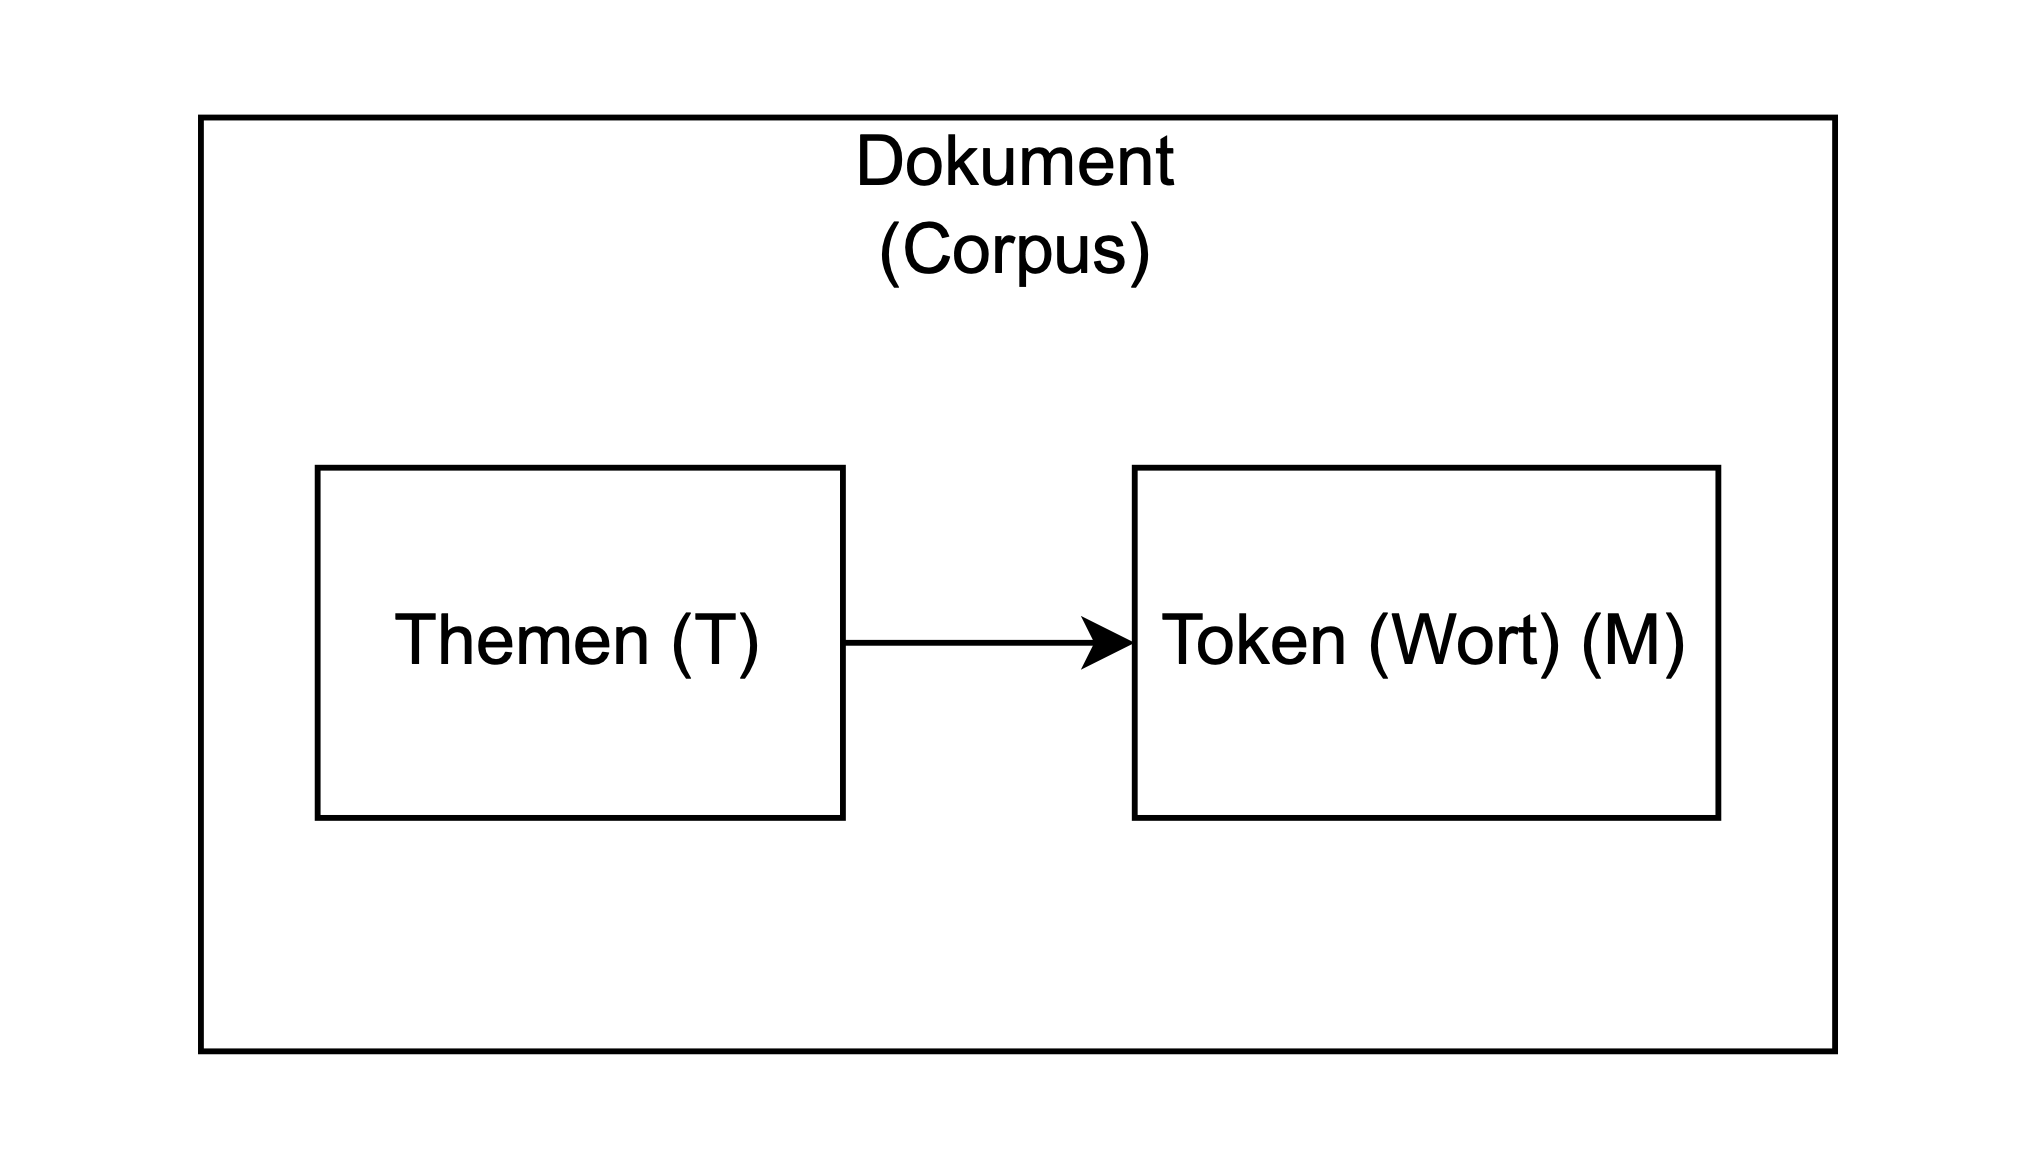


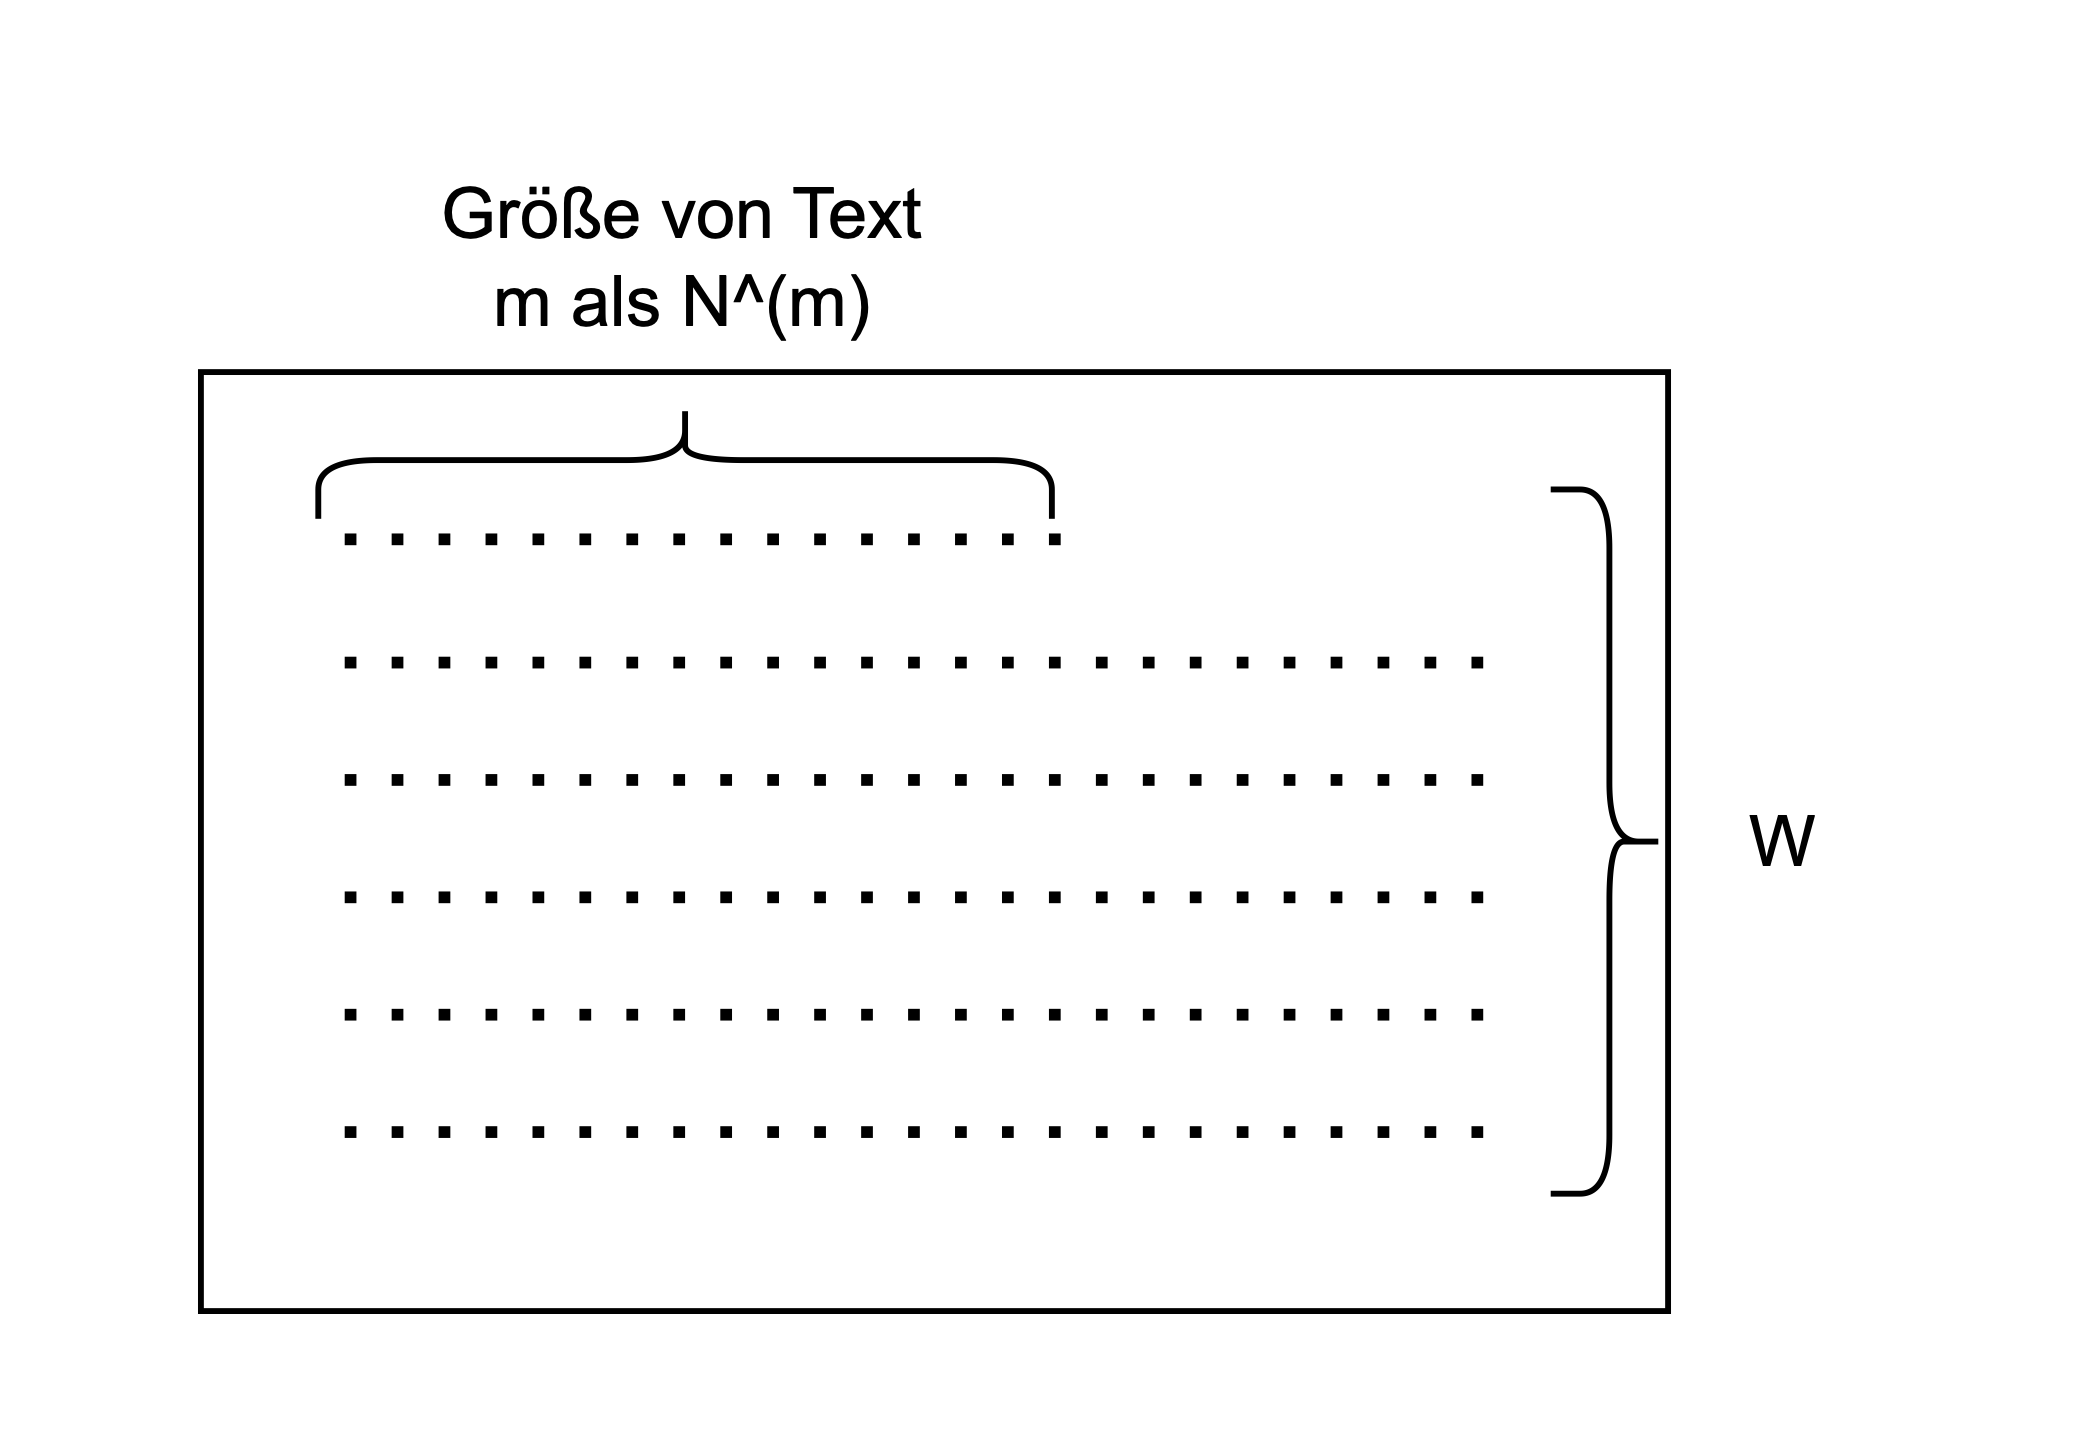

Somit besteht ein $**Dokument**$ aus:
$$D^((m))=(W_1^((m) ),…,W_(N^((m) ))^((m) ) ); m=1,…,M;W_n^((m) )∈W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

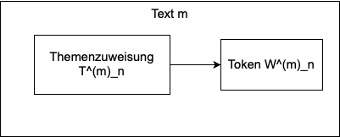

Um das Wahrscheinlichkeitsmodell für LDA aufzustellen sind folgende Definitionen und Annahmen notwendig: $n_k^((mv));k=1,…,K;v=1,…,V$ als Anzahl zugewiesener Wörter $v$ in Text $m$ zugehörig zu Thema $k$, dadurch lässt sich die Summe der Wörter $v$  in Thema $k$ über alle Dokumente $D$ mit $n_k^((*v))$ bestimmen. Wenn $w_k=(n_k^((*1)),…,n_k^((*V)) )^T$ die Vektoren der Wortanzahl für $k=1,…,K$ Themen ist, dann lässt sich mit diesen Definitionen das Modell wie folgt aufstellen:

$W_n^((m)) |T_n^((m)),ϕ_k  ~$ Discrete $(ϕ_k),		ϕ_k  ~$ Dirichlet $(η)$

$T_n^((m)) |θ_m  ~$ Discrete $(θ_m),		θ_m  ~$ Dirichlet $(α)$

Die Dirichlet Verteilungs Hyperparameter $α$ und $η$ müssen vom Nutzer deklariert werden. Da normalerweise keine a-priori (Anfangswahrscheinlichkeit) Informationen der Themen $θ$  und Wortverteilungen $ϕ$ vorliegen, werden $α$ und $η$ symmetrisch bestimmt (Rieger at al. (2020 Juni), S. 120).

Ein hoher $η$ Wert führt zu einem Verlust der Gleichmäßigkeit der Wortmischung pro Thema, ein niedriger $η$ Wert erhöht und verbessert die Gleichmäßigkeit wodurch weniger dominantere Wörter pro Thema zugeordnet werden. Nach dem gleichen Prinzip steuert α die Mischung der Themen in den Texten (Rieger at al. (2020 Juni), S. 120).

LDA ist eine Weiterentwicklung von LSI, bzw. pLSI, wobei LSI selbst eine Weiterentwicklung von tf-idf ist (Blei et al. (2003), S. 994). LSI verbessert tf-idf indem eine größere reduktion der Beschreibungslänge in großen Daten möglich ist und die statistische Struktur zwischen oder innerhalb von Dokumenten offenbart (Blei et al. (2003), S. 994; Rosario, B. (2000)). Probability LSI (pLSI) verbessert LSI dahingehend, dass alle Worte in einem Dokument eine Stichprobe aus einem Mischungsmodell sind in welchem wiederum verschiedene Themen Multinomial-Verteilungen abgebildet sind (Blei et al. (2003), S. 994). Durch die linearität des Modelles kommt es zu overfitting, zusätzlich gibt es keine Möglichkeit nicht im Training enthaltenen Dokumenten eine Wahrscheinlichkeit zuzuweisen (Blei et al. (2003), S. 994).
Um Repräsentationen von Dokumenten und Wörtern austauschbar abzubilden, ist es notwendig mixture-models zu verwenden und somit den angeführten Limitationen von LSI und verwandten Ansätzen zu entgehen (Blei et al. (2003), S. 995).

Außerdem grenzt sich LDA von Hierarchical Latent Tree Analysis (HLTA) wie folgt ab, HLTA stellt Koinzidenz Muster explizit in Modellstrukturen dar (Chen at al. (2017), S. 1). HLTA ist somit eine Methode um Themen zu erkennen, indem ein Thema anhand von Wörtern identifiziert wird, die häufig in einem Thema und selten in einem anderen Thema auftreten (Liu et al. (2014), S. 1).

In [47]:
%%time
lda_model = LdaModel(corpus=corpus, id2word=id2word,
                    num_topics=unique_categories,
                    random_state=42,
                    passes=10,
                    alpha="auto",
                    per_word_topics=True)

CPU times: total: 11min 51s
Wall time: 29min 43s


In [48]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score:", coherence_lda)

Coherence Score: 0.2489879175265674


# Step 4: pyLDAvis

In [50]:
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()

In [51]:
visualisation = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [52]:
visualisation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.384790 -0.277495       1        1  18.400672
21    -0.201099  0.376402       2        1   6.254778
20    -0.125829  0.097789       3        1   4.278877
14    -0.053462  0.026274       4        1   3.098630
9     -0.039521  0.017947       5        1   3.009399
18    -0.072702  0.039769       6        1   2.616057
30     0.050208 -0.015789       7        1   2.518649
2     -0.028854  0.012345       8        1   2.512418
19    -0.006942  0.002420       9        1   2.425836
26     0.022954 -0.008286      10        1   2.415439
34     0.003685 -0.001607      11        1   2.253194
13     0.041989 -0.013782      12        1   2.229063
7      0.003874 -0.001760      13        1   2.200940
22    -0.003543  0.001181      14        1   2.199048
8     -0.003517  0.001112      15        1   2.195667
24     0.010086 -0.004034      16        1   2.180693
4      0.003511 -0.001580      17        1   2.141463
28     0.014155 -0.005372      18        1   2.083964
16     0.030015 -0.010387      19        1   2.047960
3      0.000231 -0.000367      20        1   2.036535
32     0.021067 -0.007630      21        1   2.028158
10     0.012675 -0.004828      22        1   2.013776
27     0.031720 -0.010843      23        1   2.001653
36     0.070384 -0.020369      24        1   1.996192
6      0.033528 -0.011432      25        1   1.943116
1      0.026543 -0.009375      26        1   1.930749
35     0.035274 -0.011869      27        1   1.910535
25     0.061994 -0.018582      28        1   1.871557
17     0.041524 -0.013569      29        1   1.834489
5      0.031009 -0.010623      30        1   1.801301
29     0.048147 -0.015298      31        1   1.769353
15     0.061312 -0.018457      32        1   1.733797
12     0.050011 -0.015803      33        1   1.690631
31     0.045864 -0.014673      34        1   1.683707
33     0.042627 -0.013889      35        1   1.639081
23     0.060787 -0.018267      36        1   1.585360
0      0.065082 -0.019275      37        1   1.467263, topic_info=         Term          Freq         Total Category  logprob  loglift
1564    photo  31093.000000  31093.000000  Default  30.0000  30.0000
145       day  22331.000000  22331.000000  Default  29.0000  29.0000
3310  wedding  10341.000000  10341.000000  Default  28.0000  28.0000
921      love  12020.000000  12020.000000  Default  27.0000  27.0000
518       way  14591.000000  14591.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
582     grand    491.720873    492.800227  Topic37  -4.6456   4.2196
7507   period    485.187652    486.267005  Topic37  -4.6590   4.2195
4103  whitney    452.101570    453.180923  Topic37  -4.7296   4.2194
174    aspect    449.694410    450.773763  Topic37  -4.7350   4.2194
8723   potato    429.765423    430.844777  Topic37  -4.7803   4.2193

[1140 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
571      26  0.999369        1
212       2  0.999850       10
817      27  0.999308      100
590      13  0.998882       11
5244     14  0.999509       12
...     ...       ...      ...
2062      9  0.999654    youll
1575      3  0.999398    young
966       3  0.999865    youre
688      29  0.999238  youtube
7473      4  0.999691    youve

[1110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 22, 21, 15, 10, 19, 31, 3, 20, 27, 35, 14, 8, 23, 9, 25, 5, 29, 17, 4, 33, 11, 28, 37, 7, 2, 36, 26, 18, 6, 30, 16, 13, 32, 34, 24, 1])

saving the pyldavis visual for later comparison in Benchmarks&Visualization (link)!

In [62]:
import pickle

In [64]:
with open('visuals/vanilla_lda.pkl', 'wb') as f:
    pickle.dump(visualisation, f)

# Literaturhinweise
* Rosario, B. (2000). Latent semantic indexing: An overview. Techn. rep. INFOSYS, 240, 1-16.
* Chen, P., Zhang, N. L., Liu, T., Poon, L. K., Chen, Z., & Khawar, F. (2017). Latent tree models for hierarchical topic detection. Artificial Intelligence, 250, 105-124.
* Liu, T., Zhang, N. L., & Chen, P. (2014). Hierarchical latent tree analysis for topic detection. In Machine Learning and Knowledge Discovery in Databases: European Conference, ECML PKDD 2014, Nancy, France, September 15-19, 2014. Proceedings, Part II 14 (pp. 256-272). Springer Berlin Heidelberg.
* Rieger, J., Rahnenführer, J., & Jentsch, C. (2020, June). Improving latent Dirichlet allocation: On reliability of the novel method LDAPrototype. In International conference on applications of natural language to information systems (pp. 118-125). Cham: Springer International Publishing.
* Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
* Schütze, H., Manning, C. D., & Raghavan, P. (2008). Introduction to information retrieval (Vol. 39, pp. 234-265). Cambridge: Cambridge University Press.
* Rieger, J., Koppers, L., Jentsch, C., Rahnenfu ̈hrer, J.: Improving Reliability of Latent Dirichlet Allocation by Assessing Its Stability Using Clustering Techniques on Replicated Runs (2020)
* Heyer, Gerhard, Wiedemann, Gregor, Niekler, Andreas (2020): Topic-Modelle und ihr Potenzial für die philologische Forschung, In Lobin, Henning, Schneider, Roman, Witt, Andreas (Hrsg.): Digitale Infrastrukturen für die germanistische Forschung (S.351-353), de Gruyter, 23.07.2018.
* Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).